In [1]:
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("device is {}".format(device))

device is cuda


# Downloading Data

In [5]:
!wget www.cse.iitb.ac.in/~gowthamsridhar/data.zip

--2023-11-26 20:48:08--  http://www.cse.iitb.ac.in/~gowthamsridhar/data.zip
Resolving www.cse.iitb.ac.in (www.cse.iitb.ac.in)... 103.21.127.134
Connecting to www.cse.iitb.ac.in (www.cse.iitb.ac.in)|103.21.127.134|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cse.iitb.ac.in/~gowthamsridhar/data.zip [following]
--2023-11-26 20:48:09--  https://www.cse.iitb.ac.in/~gowthamsridhar/data.zip
Connecting to www.cse.iitb.ac.in (www.cse.iitb.ac.in)|103.21.127.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1113116819 (1.0G) [application/zip]
Saving to: ‘data.zip.3’

data.zip.3            0%[                    ] 223.57K  26.3KB/s    eta 10h 11m^C


In [6]:
!unzip data.zip

Archive:  data.zip
replace flickr8k/captions.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [7]:
input_dir = 'flickr8k/images/'
output_file = 'flickr8k/captions.txt'

In [8]:
list_of_files = os.listdir(input_dir)

# Preprocessing Images

In [9]:
def preprocess_images(input_dir):
  """
  input_dir : str : input_dir
  """
  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
    ]
  )
  image = []
  for img_name in list_of_files:
    img = preprocess(Image.open(os.path.join(input_dir,img_name)))
    image.append(img)
  return torch.stack(image).to(device)

In [10]:
def display_image(Images,num):
  T = transforms.ToPILImage()
  img = T(Images[num,:,:,:])
  plt.imshow(img)

In [11]:
Images = preprocess_images(input_dir)
Images.size()

torch.Size([8091, 3, 224, 224])

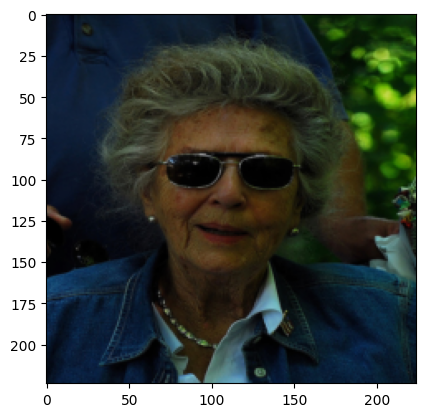

In [12]:
display_image(Images,1)

# Preprocessing Captions

In [13]:
start = "<start>"
end = "<end>"
unk = "<unk>"

In [14]:
def preprocess_text(text):
  """
  remove the digits, punctuations and change all the punctuations and all words to lower case
  this is done to make all captions contain <start>, <end>, and words in lower case
  """
  text = re.sub(r'\d+', '', text)
  text = " ".join([i.strip(string.punctuation).lower() for i in text.split()])
  text = " ".join([i for i in text.split() if len(i) > 1])
  text = text.replace('\s+', ' ').replace('\n','')
  return text


In [15]:
def preprocess_caption(output_dir):
  captions = open(output_dir, 'r').read().strip().split('\n')
  caption_dict = {}
  for row in captions[1:]:
      img_id, caption = row.split(',')[0],row.split(',')[1]
      caption = '<start> ' + preprocess_text(caption.strip()) + ' <end>'
      if img_id in caption_dict:
          caption_dict[img_id].append(caption)
      else:
          caption_dict[img_id] = [caption]

  return caption_dict

In [16]:
def tokenise_captions(captions_set):
  int_to_word = {}
  word_to_int = {}
  total_words = []
  for captions in captions_set:
    for caption in captions:
      total_words += list(filter(None,caption.split(" ")))
  unique_words = list(set(total_words))
  word_to_int = dict([(words,index+3) for index,words in enumerate(unique_words)])
  int_to_word = dict([(index+3,words) for index,words in enumerate(unique_words)])
  word_to_int[start] = 0
  word_to_int[end] = 1
  word_to_int[unk] = 2
  int_to_word[0] = start
  int_to_word[1] = end
  int_to_word[2] = unk
  return int_to_word,word_to_int

In [17]:
def encoding_captions(int_to_word, word_to_int,captions_set):
  encoded_captions = []
  for index,captions in enumerate(captions_set):
    for ind,caption in enumerate(captions):
      seq = []
      text = list(filter(None,caption.split(" ")))
      for word in text:
        if word in word_to_int.keys():
          seq.append(word_to_int[word])
        else:
          seq.append(word_to_int["<unk>"])
      encoded_captions.append((torch.tensor(seq)))
  return encoded_captions

In [18]:
caption_dict = preprocess_caption(output_file)

# Train-Validation split

In [19]:
train_split = int(0.8*len(list_of_files))
val_split = ((len(list_of_files) - train_split)//2 )
test_split = len(list_of_files) - train_split - val_split

train_files = list_of_files[:train_split]
validation_files = list_of_files[train_split:train_split+val_split]
test_files = list_of_files[train_split+val_split:]


train_images = Images[:train_split,:,:,:]
validation_images = Images[train_split:train_split+val_split,:,:,:]
test_images = Images[train_split+val_split:,:,:,:]


In [20]:
train_captions = [caption_dict[file] for file in train_files]
vocab = tokenise_captions(train_captions)
encoded_train_captions = encoding_captions(vocab[0],vocab[1],train_captions)

In [21]:
val_captions = [caption_dict[file] for file in validation_files]
encoded_val_captions = encoding_captions(vocab[0],vocab[1],val_captions)

['<start> man in an orange cap standing on top of pointy rock <end>', '<start> man in brown pants <end>', '<start> man is standing on the top of rock <end>', '<start> man wearing an orange cap and brown cargo pants stands on rock by some green trees <end>', '<start> man wearing an orange cap <end>']


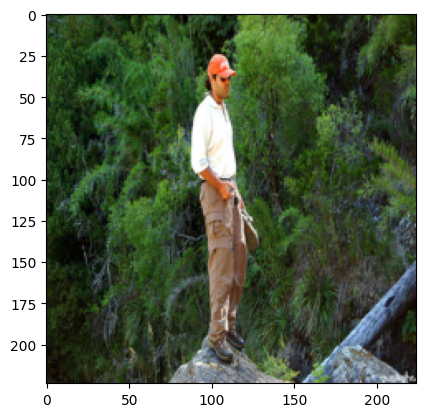

In [22]:
print(train_captions[0])
display_image(train_images,0)

In [23]:
print(train_images.shape)
print(len(vocab[0]))
print(len(train_files))
print((len(train_captions)))

torch.Size([6472, 3, 224, 224])
7825
6472
6472


# Captions Dataset

In [24]:
class CaptionDataset(Dataset):
  def __init__(self,images,encoded_captions,split,captions_per_images):
    self.images = images
    self.captions = encoded_captions
    self.captions_per_images = captions_per_images
    self.split = split # "train","val" or "test"
    self.dataset_size = len(encoded_captions)

  def __len__(self):
    return self.dataset_size

  def get_train_indices(self):
    indices = []
    randomised_captions = np.random.choice(list(range(5)),len(self.images),replace = True)
    indices = randomised_captions + np.array(list(range(len(self.images))))*5
    return list(indices)

  def __getitem__(self,index):
    # print("index:",index//self.captions_per_images)
    img = self.images[(index//self.captions_per_images),:,:,:]
    caption = self.captions[index]
    # print(type(caption))
    caplen = len(caption)
    if self.split == "train":
      return img,caption,caplen
    else :
      return img,self.captions[(index // self.captions_per_images)*self.captions_per_images:((index // self.captions_per_images) + 1)*self.captions_per_images-1]


In [25]:
train_dataset = CaptionDataset(train_images,encoded_train_captions,"train",5)
train_loader = DataLoader(train_dataset,shuffle = True)

In [26]:
validation_captions = []
for caption_set in val_captions:
  for captions in caption_set:
    validation_captions.append(captions)
val_dataset = CaptionDataset(validation_images,validation_captions,"val",5)
val_loader = DataLoader(val_dataset)

In [27]:

for data in val_loader:
  print(data)
  break

[tensor([[[[0.2353, 0.2000, 0.2471,  ..., 0.6431, 0.6118, 0.5333],
          [0.2196, 0.2078, 0.2471,  ..., 0.6196, 0.6471, 0.5804],
          [0.1765, 0.1765, 0.2314,  ..., 0.5686, 0.6039, 0.6275],
          ...,
          [0.8078, 0.7686, 0.6510,  ..., 0.0588, 0.0431, 0.0510],
          [0.5647, 0.7373, 0.7373,  ..., 0.0667, 0.0588, 0.0588],
          [0.7373, 0.7961, 0.7490,  ..., 0.0980, 0.0902, 0.0902]],

         [[0.3020, 0.2667, 0.3059,  ..., 0.6000, 0.5647, 0.4941],
          [0.2784, 0.2706, 0.3059,  ..., 0.5843, 0.6078, 0.5412],
          [0.2392, 0.2392, 0.2902,  ..., 0.5294, 0.5686, 0.5725],
          ...,
          [0.8078, 0.7725, 0.6392,  ..., 0.0588, 0.0392, 0.0471],
          [0.5412, 0.7294, 0.7569,  ..., 0.0627, 0.0588, 0.0588],
          [0.7294, 0.7765, 0.7176,  ..., 0.0980, 0.0902, 0.0902]],

         [[0.2431, 0.2000, 0.2471,  ..., 0.5412, 0.5098, 0.4706],
          [0.2431, 0.2235, 0.2471,  ..., 0.5020, 0.5255, 0.4941],
          [0.2000, 0.2078, 0.2627,  ..., 

# CNN encoder part of the model

In [102]:
class CNN_model_1(nn.Module):
    #vgg 19
    def __init__(self, embed_size):
        super(CNN_model_1, self).__init__()
        vgg = models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad_(False)

        modules = list(vgg.children())[:-1]
        self.vgg = nn.Sequential(*modules)
        self.embed = nn.Linear(25088, embed_size)
        self.embed.weight.data.normal_(0.0, 0.02)
        self.embed.bias.data.fill_(0)

    def forward(self, images):
        features = self.vgg(images)
        features = features.reshape(features.size(0), -1)
        return self.embed(features)


In [101]:
from torchvision.models.resnet import resnet152
class CNN_model_2(nn.Module):
  # ResNet model
  def __init__(self,embed_size):
    super(CNN_model_2,self).__init__()
    resnet = models.resnet152(pretrained = True)
    for param in resnet.parameters():
      param.requires_grad_(False)
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.linear = nn.Linear(resnet.fc.in_features,embed_size)
    self.linear.weight.data.normal_(0.0, 0.02)
    self.linear.bias.data.fill_(0)

  def forward(self, images):
    features = self.resnet(images)
    # print(features.shape)
    features = features.reshape(features.size(0), -1)
    # print(features.shape)
    return self.linear(features)

In [72]:
class CNN_model_3(nn.Module):
  # Inception v3 model
  def __init__(self, embed_size):
        super(CNN_model_3, self).__init__()
        inception = models.inception_v3(pretrained=True)
        for param in inception.parameters():
            param.requires_grad_(False)

        modules = list(inception.children())[:-1]
        self.inception = nn.Sequential(*modules)
        self.embed = nn.Linear(inception.fc.in_features, embed_size)
        self.embed.weight.data.normal_(0.0, 0.02)
        self.embed.bias.data.fill_(0)

  def forward(self, images):
        features = self.inception(images)
        features = features.view(features.size(0), -1)
        return self.embed(features)

In [73]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN,self).__init__()
        resnet=models.resnet50(pretrained=True)
        for p in resnet.parameters():
            p.requires_grad_(False)
        modules=list(resnet.children())[:-2]
        self.resnet=nn.Sequential(*modules)
    def forward(self,images):
        features=self.resnet(images)
        features=features.permute(0,2,3,1)
        features=features.view(features.size(0),-1,features.size(-1))
        return features #(batch_size,49,2048)

### Attention


In [74]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

# LSTM and Transformer part of the decoder

### LSTM with attention

In [75]:
import torch
import torch.nn as nn

class LSTMWithAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, attention_dim, n_layers=1):
        super(LSTMWithAttention, self).__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.n_layers = n_layers

        # Define layers
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.attention = Attention(hidden_dim, hidden_dim, attention_dim)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        # Remove the last token from each caption
        captions = captions[:, :-1]
        print(captions.size(0))
        # Get embeddings for the captions
        embeddings = self.embeddings(captions)

        # Concatenate image features and caption embeddings
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)

        # Initialize hidden and cell states
        hidden = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)
        cell = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(inputs, (hidden, cell))

        # Attention mechanism
        attended_encoding, _ = self.attention(lstm_out, features.unsqueeze(1))

        # Linear layer for prediction
        output = self.linear(attended_encoding)

        return output

    def sample(self, features, max_len=40):
        # Initialize inputs for the first time step
        inputs = features
        print(features.size(0))
        sampled_captions = []

        # Initialize hidden and cell states
        hidden = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)
        cell = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)

        for _ in range(max_len):
            # LSTM forward pass
            lstm_out, (hidden, cell) = self.lstm(inputs, (hidden, cell))

            # Attention mechanism
            attended_encoding, _ = self.attention(lstm_out, features.unsqueeze(1))

            # Linear layer for prediction
            output = self.linear(attended_encoding)
            # print(output.shape)
            # Get the predicted word indices
            output = output.squeeze(1).squeeze(1) # has to be changed if batch is introduced
            # print(output.shape)
            predicted_indices = output.max(dim = 1)[1]
            # print(predicted_indices)

            # Append the predicted word indices to the sampled captions
            sampled_captions.append(predicted_indices.item())

            # Update inputs for the next time step
            inputs = self.embeddings(predicted_indices.unsqueeze(1))

        return sampled_captions


Real Attention

In [76]:
class BahadnauAttention(nn.Module):
    def __init__(self):
        super(BahadnauAttention,self).__init__()
        self.U=nn.Linear(512,512)
        self.W=nn.Linear(2048,512)
        self.v=nn.Linear(512,1)
        self.tanh=nn.Tanh()
        self.softmax=nn.Softmax(1)

    def forward(self,features,hidden_states):
        U_hidden=self.U(hidden_states)#(batch_size,512)
        W_features=self.W(features)#(batch_size,49,512)
        attention=self.tanh(U_hidden.unsqueeze(1)+W_features)
        e=self.v(attention).squeeze(2) #(batch_size,1)
        alpha=self.softmax(e)
        context=(features*alpha.unsqueeze(2)).sum(1)
        return alpha,context

In [77]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()

        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = BahadnauAttention()


        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)


        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)



    def forward(self, features, captions):

        #vectorize the caption
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds,alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        alphas = []

        #starting input
        word = torch.tensor(vocab[1]['<start>']).view(1,-1).to(device)
        embeds = self.embedding(word)


        captions = []

        for i in range(max_len):
            alpha,context = self.attention(features, h)


            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab[0][predicted_word_idx.item()] == "<end>":
                break

            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return " ".join([vocab[0][idx] for idx in captions])


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

# Integrating the 2 parts of the model

In [78]:
class Model(nn.Module):
  def __init__(self,encoder,decoder,embed_size,hidden_size,vocab_size):
    """
    takes input for all the classes and creates the model
    """
    super(Model,self).__init__()
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,images,captions):
    features = self.encoder(images)
    outputs,alpha = self.decoder(features,captions)
    return features,outputs,alpha

  def evaluate_and_sample(self,image):
    features = self.encoder(image).unsqueeze(1)
    prediction = self.decoder.generate_captions(features)
    return prediction


In [79]:
# class EncoderDecoder(nn.Module):
#     def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
#         super().__init__()
#         self.encoder = EncoderCNN()
#         self.decoder = DecoderRNN(
#             embed_size=embed_size,
#             vocab_size = len(dataset.vocab),
#             attention_dim=attention_dim,
#             encoder_dim=encoder_dim,
#             decoder_dim=decoder_dim
#         )

#     def forward(self, images, captions):
#         features = self.encoder(images)
#         outputs = self.decoder(features, captions)
#         return outputs

In [80]:
# def generate_captions(model,image):
#   model.eval()
#   predicted_captions = model.evaluate_and_sample(image)
#   sentence = ""
#   for idx in predicted_captions:
#     word = vocab[0][idx]
#     if word != "<end>" and word != '<start>':
#       sentence += vocab[0][idx] + " "
#     elif word == '<end>':
#       break
#   return sentence

In [81]:
def validate(model):
  actual_captions = []
  generated_captions = []
  for data in val_loader:
    image, caption_set = data
    # print(image,caption_set)
    actual_captions.append([caption[0].split() for caption in caption_set])
#     print(vocab[1])
    generated_captions.append(model.decoder.generate_caption(model.encoder(image.to(device)), vocab = vocab).split())
  bleu1 = corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))
  bleu4 = corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
  bleu = (bleu1*bleu2*bleu3*bleu4)**0.25
  print(f'BLEU-1: {bleu1}')
  print(f'BLEU-2: {bleu2}')
  print(f'BLEU-3: {bleu3}')
  print(f'BLEU-4: {bleu4}')
  print(f'BLEU:{(bleu1*bleu2*bleu3*bleu4)**0.25}')
  return bleu

In [82]:
def train(model,lossfn,optimizer,train_loader,validation_loader = None,num_epochs = 30):
      model.train()
      best_checkpoint_model,best_bleu = None,0
      for epoch in range(1, num_epochs+1):
            model.train()
            average_loss = 0
            count = 0
            average_perp = 0
            indices = train_loader.dataset.get_train_indices()
            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            for i,(img,cap,caplen) in tqdm(enumerate(train_loader)):
                img = img.to(device)
                cap = cap.to(device)
                model.zero_grad()
                features,outputs,alpha = model(img,cap)
                loss = lossfn(outputs.view(-1, model.vocab_size), cap[:,1:].reshape(-1))
                loss.backward()
                optimizer.step()
                # if i%100 == 0:
                #   print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,i,len(train_loader),loss.item(), np.exp(loss.item())))
                count += 1
                average_loss += loss.item()
                perp = np.exp(loss.item())
            average_loss = average_loss/count
#             average_perp = average_perp / count
            print('Epoch [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,average_loss, perp))
            bleu = validate(model)
            if bleu > best_bleu:
              print("checkpointing best model")
              best_checkpoint_model = model
              best_bleu = bleu
      return model,best_checkpoint_model

        # # Print training statistics (on same line).
        #     # print('\r' + stats, end="")
        #     # sys.stdout.flush()

        #     # # Print training statistics to file.
        #     # f.write(stats + '\n')
        #     # f.flush()

        #     # # Print training statistics (on different line).
        #     # if i_step % print_every == 0:
        #     #     print('\r' + stats)

        # # Save the weights.
        # if epoch % save_every == 0:
        #     torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        #     torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Calling Functions

In [106]:
learning_rate = 0.0003
num_epochs = 1
embed_size=300
hidden_size=512
attention_size = 256
vocab_size=len(vocab[0])
# print(vocab_size)
n_layers=2

In [107]:
# decoder = LSTM_model_1(embed_size,hidden_size,vocab_size,n_layers)
# decoder = DecoderRNN(embed_size,hidden_size,vocab_size,n_layers)
# decoder = LSTMWithAttention(embed_size, hidden_size, vocab_size, attention_size, n_layers)
# encoder = CNN_model_1(embed_size=embed_size)
# model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
# model = model.to(device)

In [109]:
# decoder = (embed_size,hidden_size,vocab_size,n_layers)
decoder = DecoderRNN(embed_size,vocab_size,attention_size,2048,hidden_size)
# decoder = LSTMWithAttention(embed_size, hidden_size, vocab_size, attention_size, n_layers)
encoder = EncoderCNN()
model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [110]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [111]:
train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 5)

6472it [03:45, 28.64it/s]


Epoch [1/5], Loss: 5.0199, Perplexity: 357.8055
BLEU-1: 0.3817752238534077
BLEU-2: 0.16355984207939367
BLEU-3: 0.07357994584487548
BLEU-4: 0.036618359599457785
BLEU:0.11389002624383185
checkpointing best model


6472it [03:47, 28.51it/s]


Epoch [2/5], Loss: 4.5157, Perplexity: 355.7019
BLEU-1: 0.38598927408542427
BLEU-2: 0.1632632247327284
BLEU-3: 0.07771324560163433
BLEU-4: 0.04032186088555535
BLEU:0.11854269740177488
checkpointing best model


6472it [03:45, 28.74it/s]


Epoch [3/5], Loss: 4.3420, Perplexity: 447.6140
BLEU-1: 0.366058547825543
BLEU-2: 0.15990845299024453
BLEU-3: 0.07817989747997205
BLEU-4: 0.04212566129922254
BLEU:0.11783273295694936


6472it [03:44, 28.84it/s]


Epoch [4/5], Loss: 4.2500, Perplexity: 679.0214
BLEU-1: 0.3805074855008029
BLEU-2: 0.17080095067930992
BLEU-3: 0.08616180331775315
BLEU-4: 0.046006659463966225
BLEU:0.1266914311711074
checkpointing best model


6472it [03:44, 28.83it/s]


Epoch [5/5], Loss: 4.1503, Perplexity: 30245.0356
BLEU-1: 0.3665220247881828
BLEU-2: 0.15820597467809616
BLEU-3: 0.07491680397849
BLEU-4: 0.04034393249648731
BLEU:0.11505887066434084


(Model(
   (encoder): EncoderCNN(
     (resnet): Sequential(
       (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace=True)
       (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (4): Sequential(
         (0): Bottleneck(
           (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (relu): ReLU(inplace=

In [112]:
train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 5)

6472it [03:45, 28.75it/s]


Epoch [1/5], Loss: 4.2201, Perplexity: 119777.2044
BLEU-1: 0.3741124005604997
BLEU-2: 0.15881485970191958
BLEU-3: 0.07984550519822696
BLEU-4: 0.04228986131473344
BLEU:0.11901316183212446
checkpointing best model


6472it [03:46, 28.58it/s]


Epoch [2/5], Loss: 4.1730, Perplexity: 29151.1927
BLEU-1: 0.38118752666742955
BLEU-2: 0.1644175848204405
BLEU-3: 0.08250868050726097
BLEU-4: 0.04362275449925471
BLEU:0.12255327406274656
checkpointing best model


6472it [03:46, 28.54it/s]


Epoch [3/5], Loss: 4.1011, Perplexity: 23343.9600
BLEU-1: 0.38634970339299834
BLEU-2: 0.1628125034546303
BLEU-3: 0.079429989335377
BLEU-4: 0.04185669735654574
BLEU:0.12025536197123


6472it [03:46, 28.57it/s]


Epoch [4/5], Loss: 4.0911, Perplexity: 8843.5567
BLEU-1: 0.375762444174148
BLEU-2: 0.15962001370634077
BLEU-3: 0.08052521626668105
BLEU-4: 0.04265496831531995
BLEU:0.11980517003183917


6472it [03:46, 28.52it/s]


Epoch [5/5], Loss: 4.0691, Perplexity: 38710.8119
BLEU-1: 0.37889085621206986
BLEU-2: 0.15910499242405451
BLEU-3: 0.07857216172333317
BLEU-4: 0.04095013498533301
BLEU:0.11801317449771301


(Model(
   (encoder): EncoderCNN(
     (resnet): Sequential(
       (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace=True)
       (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (4): Sequential(
         (0): Bottleneck(
           (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (relu): ReLU(inplace=

# Generating Captions

In [ ]:
# i = 0
# for data in train_loader:
#   if i == 29:

#     image = (data[0]).to(device)
#     captions = generate_captions(model,image)
#     print(captions)
#     T = transforms.ToPILImage()
#     img = T(image.squeeze())
#     plt.imshow(img)
#   i+=1
#   if i > 36:

#     break

In [ ]:
# actual_captions = []
# generated_captions = []
# for data in val_loader:
#   image, caption_set = data
#   print(image.size())
#   for k in range(image.size()[0]):
#         features=model.encoder(image[k].unsqueeze(0).to(device))
#         caps,alpha=model.decoder.generate_caption(features,vocab=vocab[0])
#         reference=[vocab[0][i] for i in caption_set[k].tolist() if vocab[0][i]!="<PAD>"]
#         actual_captions.append(reference)
#         generated_captions.append(caps)
#   # print(image,caption_set)
#   # actual_captions.append([caption[0].split() for caption in caption_set])
#   # generated_captions.append(generate_captions(model,image).split())

# print(f'BLEU-1: {corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))}')
# print(f'BLEU-2: {corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))}')
# print(f'BLEU-3: {corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))}')
# print(f'BLEU-4: {corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))}')